CLASSIFY SONG GENRES FROM AUDIO DATA

Streaming services have taken over the music industry over the past few years. The extensive amount of music provided through these streaming services allow users to access their favourite music but it can also be overwhelming when trying to discover new songs.

Today, we will be examining data compiled by a research group known as The Echo Nest to categorize music to allow for personalized recommendations.
Our goal is to look through this dataset and classify songs as being either 'Hip-Hop' or 'Rock' - all without listening to a single one ourselves. 

In doing so, we will have to clean our data, do some exploratory data visualization, and use feature reduction towards the goal of feeding our data through some simple machine learning algorithms, such as decision trees and logistic regression.

1. Preparing Our Dataset

Let's load the data about our tracks alongside the track metrics compiled by The Echo Nest.

In [92]:
import pandas as pd 

tracks = pd.read_csv('./fma-rock-vs-hiphop.csv')
echonest_metrics = pd.read_json('./echonest-metrics.json', precise_float=True)

# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = pd.merge(echonest_metrics, tracks[['track_id', 'genre_top']], on='track_id')

print(echo_tracks.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB
None


2. Pairwise Relationships Between Continuous Variables

To avoid feature redundancy, we want to find any strongly correlated features in our data and avoid these variables by using the built-in functions in the pandas package.

In [93]:
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


3. Normalizing The Feature Data

Since no variables had a strong correlation with the highest r value being less than 0.5, we can proceed with reducing the number of features through a popular approach called principal component analysis (PCA). However, we first have to normalize the data through standardization to avoid biases. 

In [94]:
from sklearn.preprocessing import StandardScaler

features = echo_tracks.drop(['track_id', 'genre_top'], axis = 1)
labels = echo_tracks['genre_top']

scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

print(scaled_train_features)


[[-0.19121034  1.30442004  0.03831594 ...  0.37303429  1.15397908
   0.46228696]
 [-0.30603598  0.50188641  0.78817624 ...  2.44615517  0.00791367
  -0.69081137]
 [-1.20481276  1.68413943  0.31285194 ...  0.13513049 -0.77731688
   0.63107745]
 ...
 [-1.29470431  1.17682795  0.13265633 ...  0.85182206 -0.93541008
  -0.07941825]
 [-1.13869115 -0.02253433  0.57117905 ...  1.40951543  1.31301348
   0.47513794]
 [-0.90611434  1.10148973  0.56322452 ...  1.36030881 -1.43669053
   0.76217464]]


4. Principal Component Analysis On Our Scaled Data

We can now use PCA to reduce the number of variables in our dataset while preserving as much information as possible. We can visualize this through a Scree-Plot and a Cumulative Explained Variance Plot.

[0.24297674 0.18044316 0.13650309 0.12994089 0.11056248 0.08302245
 0.06923783 0.04731336]


Text(0.5, 0, 'Component Number')

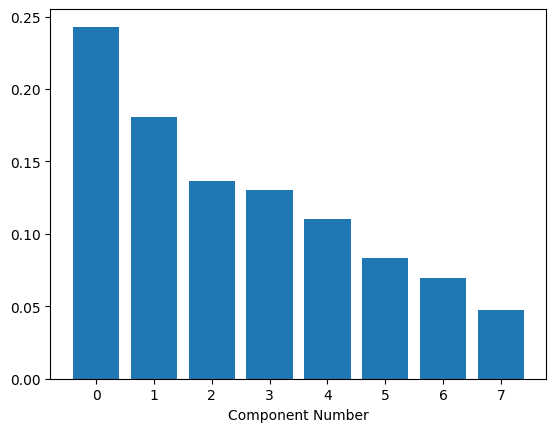

In [95]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(scaled_train_features)

exp_variance = pca.explained_variance_ratio_
print(exp_variance)

fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Component Number')

Scree-Plots help us show which components explain a sufficient amount of variance in our data. An appropriate cutoff is typically denoted with a steep drop from one data point to another. Since a steep dropoff does not occur in our plot above, we will proceed with visualizing a Cumulative Explained Variance Plot. 

This plot will determine how many features explain (our arbitrary value of) 90% of the variance. We can use this cutoff to determine the appropriate number of components that we will preserve and use in our PCA.

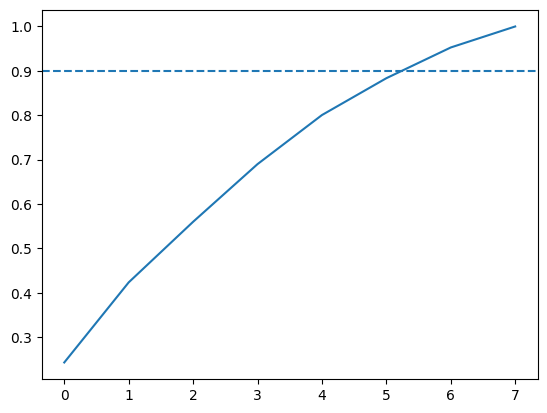

In [96]:
import numpy as np

cum_exp_variance = np.cumsum(exp_variance)

fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.9, linestyle = '--')

# 6 components make up about 90% of our variance 
n_components = 6

pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)


5. Train A Decision Tree To Classify Genre


We can now classify songs into genres using our PCA projection of the data through a Decision Tree. We will split our dataset into 'train' and 'test' subsets where the former will be used to train our model while the latter subset will evaluate the performance of our model.   

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels, random_state=10)

tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)

pred_labels_tree = tree.predict(test_features)
tree.score(test_features, test_labels)


0.8434637801831807

6. Comparing Our Decision Tree

Let's compare the results from our decision tree to another model. We will apply Logistic Regression to our dataset to predict an outcome by analyzing all of our features. We will then compare our two models on various performance metrics. 

In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

logreg.score(test_features, test_labels)

class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)

print('Decision Tree: \n', class_rep_tree)
print('Logistic Regression: \n', class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.60      0.60      0.60       235
        Rock       0.90      0.90      0.90       966

    accuracy                           0.84      1201
   macro avg       0.75      0.75      0.75      1201
weighted avg       0.84      0.84      0.84      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



7. Balancing Our Data

The results above show that both models produce similar outcomes. Furthermore, we notice that Rock songs are classified accurately, however, Hip-Hop songs are misclassified at a high rate. 

In [99]:
print((echo_tracks['genre_top']=='Rock').sum())
print((echo_tracks['genre_top']=='Hip-Hop').sum())

3892
910


By looking at our dataset, we see that we have almost 4 times the amount of Rock than Hip-Hop songs. This shows that our model's accuracy could be driven by it's ability to classify rock songs. 

We will balance our dataset by weighing the value of a correct classification in each class, with the need to only account for differences in the sample size of our data points and look to see if this improves model bias.

In [119]:
hip_only = echo_tracks[echo_tracks['genre_top']=='Hip-Hop']
rock_only = echo_tracks[echo_tracks['genre_top']=='Rock']

rock_only = rock_only.sample(len(hip_only), random_state=10)

rock_hip_bal = pd.concat([rock_only, hip_only])

features = rock_hip_bal.drop(['genre_top', 'track_id'], axis=1)
labels = rock_hip_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels, random_state=10)

tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)

logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

print('Decision Tree: \n', classification_report(test_labels, pred_labels_tree))
print('Logistic Regression: \n', classification_report(test_labels, pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.74      0.73      0.74       230
        Rock       0.73      0.74      0.73       225

    accuracy                           0.74       455
   macro avg       0.74      0.74      0.74       455
weighted avg       0.74      0.74      0.74       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.80      0.82       230
        Rock       0.80      0.85      0.83       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.82      0.82      0.82       455



We can see that the overall model performs slightly worse than before, however, the classifications between Hip-Hop and Rock songs are more balanced.

8. Evaluating Our Models Using Cross Validation 

We can apply Cross Validation (CV) to further compare our models and get a good sense of how they are performing. CV will attempt to split our data multiple ways and test our model on each split. Specifically, we will be using K-Fold Cross Validation. 

We will then aggregate the results from each fold to produce a final model performance score. 

In [131]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(10, random_state=10, shuffle=True)

tree= DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)

tree_score = cross_val_score(tree, pca_projection, labels, cv=kf)
logit_score = cross_val_score(logreg, pca_projection, labels, cv=kf)

print("Decision Tree: \n", tree_score)
print("Logistic Regression: \n", logit_score)

Decision Tree: 
 [0.76923077 0.79120879 0.77472527 0.75824176 0.75274725 0.75824176
 0.79120879 0.7967033  0.74175824 0.78571429]
Logistic Regression: 
 [0.78021978 0.83516484 0.84615385 0.82417582 0.84065934 0.75274725
 0.85164835 0.80769231 0.82417582 0.86813187]
